In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# География покупателей

In [33]:
customers_df = pd.read_csv('customers.csv')
good_customers_df = pd.read_csv('good_cust_with_ord_id.csv')

In [34]:
good_customers_geo = pd.merge(
    good_customers_df, customers_df, on='customer_unique_id', how='left'
)

city_distribution = good_customers_geo['customer_city'].value_counts().reset_index()
city_distribution.columns = ['city', 'good_customer_count']

state_distribution = good_customers_geo['customer_state'].value_counts().reset_index()
state_distribution.columns = ['state', 'good_customer_count']


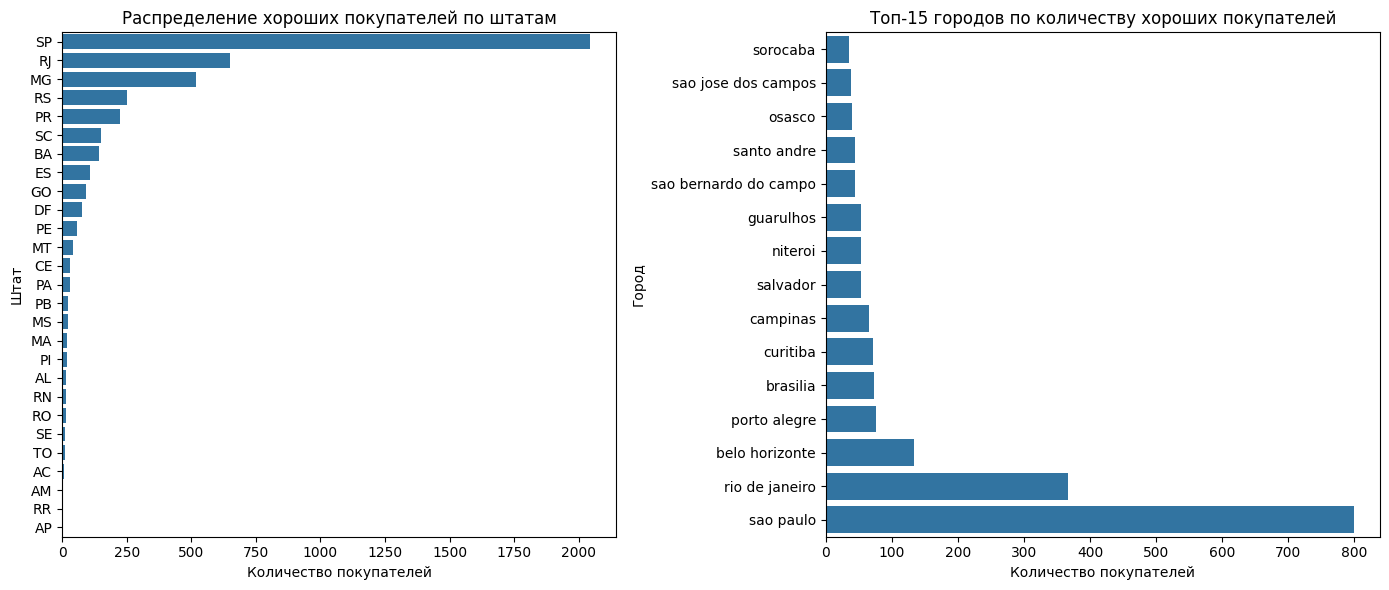

In [38]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=state_distribution.sort_values(by='good_customer_count', ascending=False),
            x='good_customer_count', y='state')
plt.title('Распределение хороших покупателей по штатам')
plt.xlabel('Количество покупателей')
plt.ylabel('Штат')

top_cities = city_distribution.head(15)

plt.subplot(1, 2, 2)
sns.barplot(data=top_cities.sort_values(by='good_customer_count', ascending=True),
            x='good_customer_count', y='city')
plt.title('Топ-15 городов по количеству хороших покупателей')
plt.xlabel('Количество покупателей')
plt.ylabel('Город')

plt.tight_layout()
plt.show()


In [39]:
cust_with_ord = pd.read_csv('customers_with_orders.csv')
bad_customers_df = cust_with_ord.groupby("customer_unique_id").filter(lambda x: x["customer_unique_id"].count() < 2)

bad_customers_geo = pd.merge(
    bad_customers_df, customers_df, on='customer_unique_id', how='left'
)

bad_city_distribution = bad_customers_geo['customer_city_x'].value_counts().reset_index()
bad_city_distribution.columns = ['city', 'bad_customer_count']

bad_state_distribution = bad_customers_geo['customer_state_x'].value_counts().reset_index()
bad_state_distribution.columns = ['state', 'bad_customer_count']


In [40]:
bad_state_distribution['relative_percentage'] = (bad_state_distribution['bad_customer_count'] / 
                                                  bad_state_distribution['bad_customer_count'].sum()) * 100

state_distribution['relative_percentage'] = (state_distribution['good_customer_count'] / 
                                              state_distribution['good_customer_count'].sum()) * 100

comparison_df = pd.merge(state_distribution, bad_state_distribution, on='state', how='inner', suffixes=('_good', '_bad'))
comparison_df['percentage_difference'] = comparison_df['relative_percentage_good'] - comparison_df['relative_percentage_bad']

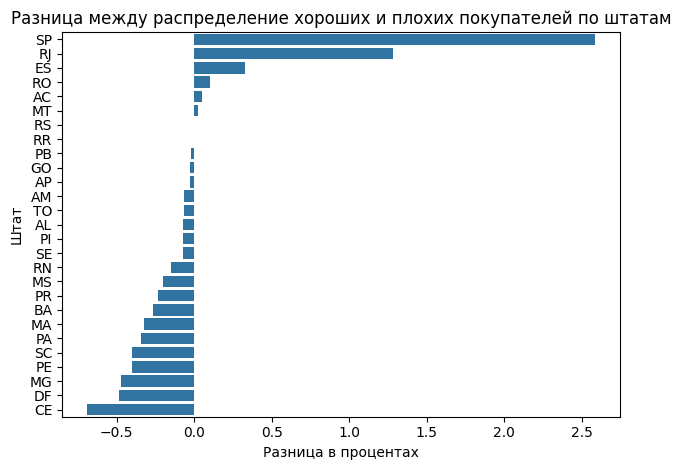

In [42]:
sns.barplot(data=comparison_df.sort_values(by='percentage_difference', ascending=False),
            x='percentage_difference', y='state')
plt.title('Разница между распределение хороших и плохих покупателей по штатам')
plt.xlabel('Разница в процентах')
plt.ylabel('Штат')
plt.tight_layout()
plt.show()

В больших штатах не сильно, но больше хороших покупателей. Учитывая, что их всего 3 процента, разница в 2.5 и 1.5 наверное не такая и маленькая

# География продавцов

Решил посмотреть на распределения продавцов, у которых покупают хорошие и плохие

In [48]:
orders_df = pd.read_csv('orders.csv')
customers_df = pd.read_csv('customers.csv')
good_customers_df = pd.read_csv('good_cust_with_ord_id.csv')
order_items_df = pd.read_csv('orders_items.csv')
sellers_df = pd.read_csv('sellers.csv')

orders_with_unique = pd.merge(
    orders_df,
    customers_df[['customer_id', 'customer_unique_id']],
    on='customer_id',
    how='left'
)

orders_good = pd.merge(
    orders_with_unique,
    good_customers_df,
    on='customer_unique_id',
    how='inner'
)

orders_good['order_type'] = orders_good.apply(
    lambda row: 'first' if row['order_id'] == row['first_order_id'] else 'repeated',
    axis=1
)

orders_sellers = pd.merge(
    order_items_df[['order_id', 'seller_id']],
    orders_good[['order_id']],
    on='order_id',
    how='inner'
)

orders_sellers_geo = pd.merge(
    orders_sellers,
    sellers_df[['seller_id', 'seller_city', 'seller_state']],
    on='seller_id',
    how='left'
)

seller_state_distribution = orders_sellers_geo['seller_state'].value_counts().reset_index()
seller_state_distribution.columns = ['state', 'seller_order_count']

sp_sellers = orders_sellers_geo[orders_sellers_geo['seller_state'] == 'SP']
sp_city_distribution = sp_sellers['seller_city'].value_counts().reset_index()
sp_city_distribution.columns = ['city', 'seller_order_count']

seller_state_distribution['relative_percentage'] = (seller_state_distribution['seller_order_count'] / 
                                                    seller_state_distribution['seller_order_count'].sum()) * 100

sp_city_distribution['relative_percentage'] = (sp_city_distribution['seller_order_count'] / 
                                                sp_city_distribution['seller_order_count'].sum()) * 100


C:\Users\Vladimir\AppData\Local\Temp\ipykernel_1064\2641733232.py:4: DtypeWarning: Columns (1,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  order_items_df = pd.read_csv('orders_items.csv')


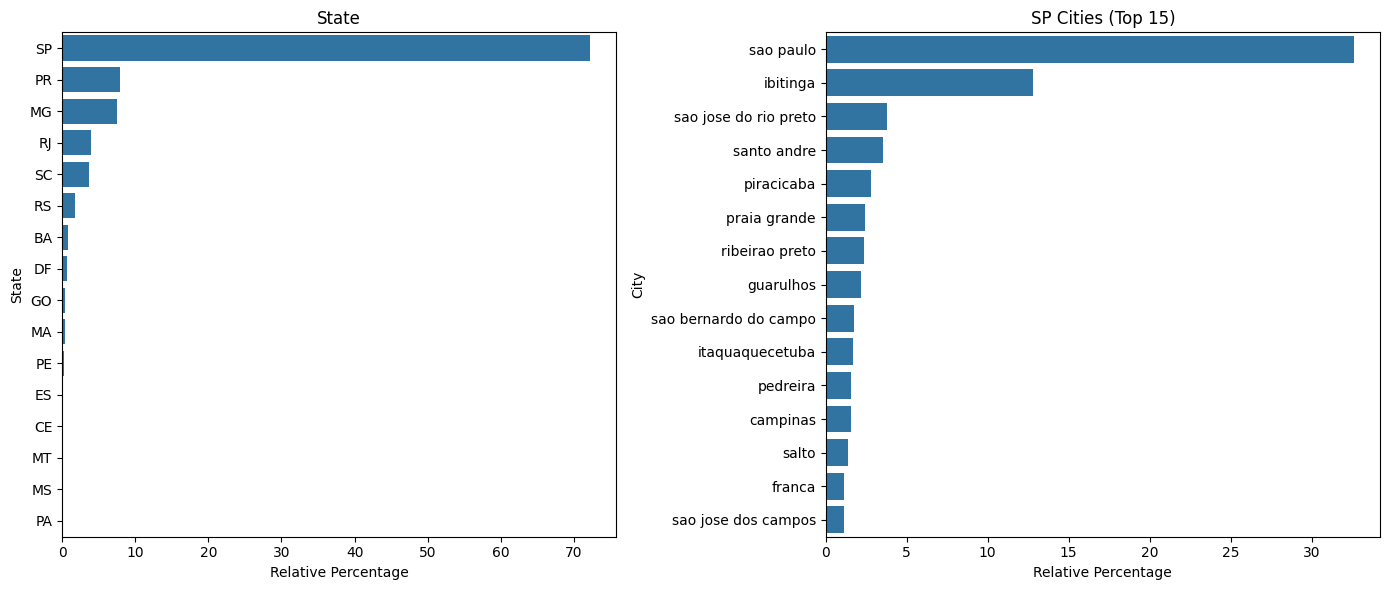

In [49]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=seller_state_distribution.sort_values(by='relative_percentage', ascending=False),
            x='relative_percentage', y='state')
plt.title('State')
plt.xlabel('Relative Percentage')
plt.ylabel('State')
plt.subplot(1, 2, 2)
sns.barplot(data=sp_city_distribution.sort_values(by='relative_percentage', ascending=False).head(15),
            x='relative_percentage', y='city')
plt.title('SP Cities (Top 15)')
plt.xlabel('Relative Percentage')
plt.ylabel('City')
plt.tight_layout()
plt.show()


In [50]:
bad_customers_df = cust_with_ord.groupby("customer_unique_id").filter(
    lambda x: x["customer_unique_id"].count() < 2
).drop_duplicates(subset=["customer_unique_id"])

orders_bad = pd.merge(
    orders_df,
    bad_customers_df[['customer_id', 'customer_unique_id']],
    on='customer_id',
    how='inner'
)

orders_bad_sellers = pd.merge(
    order_items_df[['order_id', 'seller_id']],
    orders_bad[['order_id']],
    on='order_id',
    how='inner'
)

orders_bad_sellers_geo = pd.merge(
    orders_bad_sellers,
    sellers_df[['seller_id', 'seller_city', 'seller_state']],
    on='seller_id',
    how='left'
)

bad_seller_state_distribution = orders_bad_sellers_geo['seller_state'].value_counts().reset_index()
bad_seller_state_distribution.columns = ['state', 'seller_order_count']

bad_seller_state_distribution['relative_percentage'] = (
    bad_seller_state_distribution['seller_order_count'] /
    bad_seller_state_distribution['seller_order_count'].sum()
) * 100

bad_sp_sellers = orders_bad_sellers_geo[orders_bad_sellers_geo['seller_state'] == 'SP']
bad_sp_city_distribution = bad_sp_sellers['seller_city'].value_counts().reset_index()
bad_sp_city_distribution.columns = ['city', 'seller_order_count']

bad_sp_city_distribution['relative_percentage'] = (
    bad_sp_city_distribution['seller_order_count'] /
    bad_sp_city_distribution['seller_order_count'].sum()
) * 100


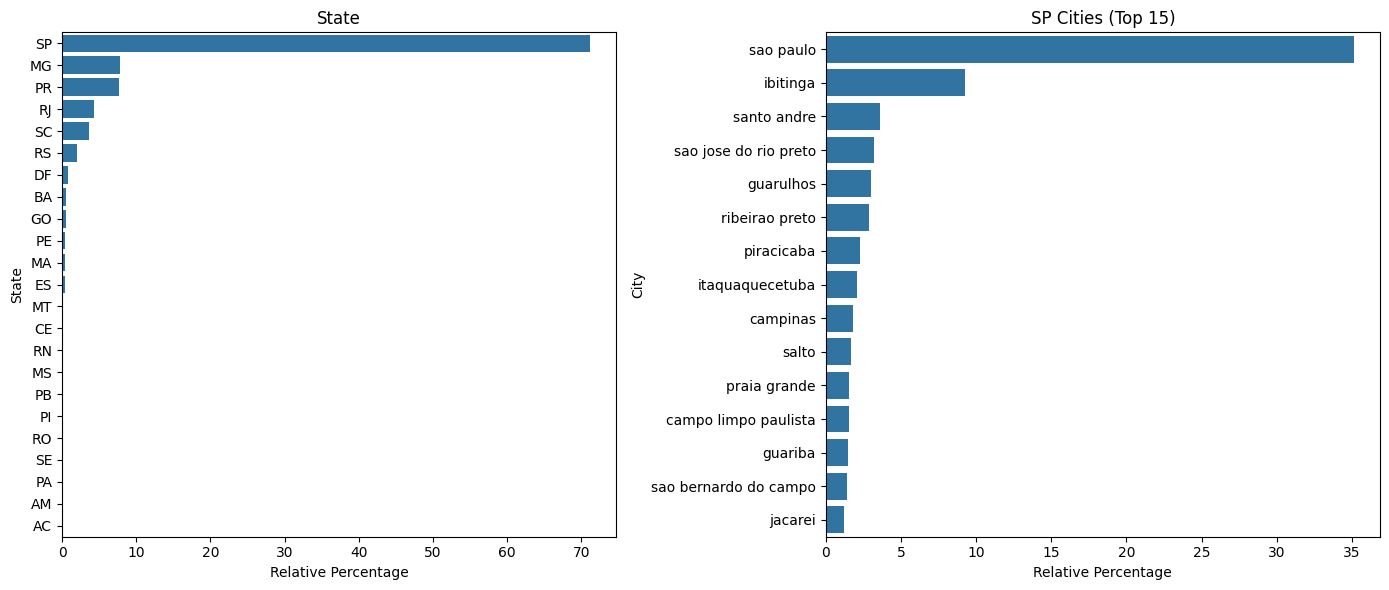

In [51]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=bad_seller_state_distribution.sort_values(by='relative_percentage', ascending=False),
            x='relative_percentage', y='state')
plt.title('State')
plt.xlabel('Relative Percentage')
plt.ylabel('State')
plt.subplot(1, 2, 2)
sns.barplot(data=bad_sp_city_distribution.sort_values(by='relative_percentage', ascending=False).head(15),
            x='relative_percentage', y='city')
plt.title('SP Cities (Top 15)')
plt.xlabel('Relative Percentage')
plt.ylabel('City')
plt.tight_layout()
plt.show()

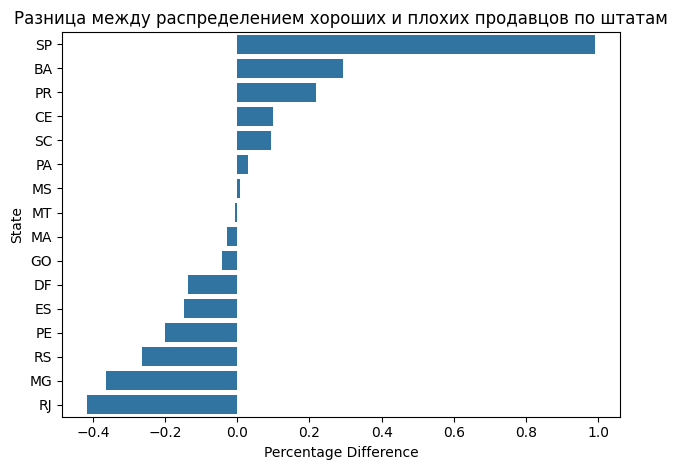

In [53]:
state_comparison = pd.merge(
    seller_state_distribution[['state', 'relative_percentage']],
    bad_seller_state_distribution[['state', 'relative_percentage']],
    on='state',
    suffixes=('_seller', '_bad_seller')
)

state_comparison['percentage_difference'] = state_comparison['relative_percentage_seller'] - state_comparison['relative_percentage_bad_seller']

sns.barplot(data=state_comparison.sort_values(by='percentage_difference', ascending=False),
            x='percentage_difference', y='state')
plt.title('Разница между распределением хороших и плохих продавцов по штатам')
plt.xlabel('Percentage Difference')
plt.ylabel('State')
plt.tight_layout()
plt.show()

Хорошими продавцами назвал тех, у кого покупают хорошие покупатели. Их незначительно, но больше в Сан-Паулу